# SVM multiclase

- **Una contra una**: si tenemos $k$ categorías $\rightarrow$ hay que crear ${k \choose 2} = \frac{k!}{(k-2)!2!}$ clasificadores 


- **Una contra todas**: si tenemos $k$ categorías $\rightarrow$ hay que crear exactamente $k$ clasificadores

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets

In [38]:
session = tf.Session()

iris = datasets.load_iris()

In [39]:
x_vals = np.array([[x[0], x[3]] for x in iris.data])

y_vals1 = np.array([1 if y == 0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y == 1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y == 2 else -1 for y in iris.target])

y_vals = np.array([y_vals1, y_vals2, y_vals3])

class1_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i] == 0]
class1_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i] == 0]

class2_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i] == 1]
class2_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i] == 1]

class3_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i] == 2]
class3_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i] == 2]

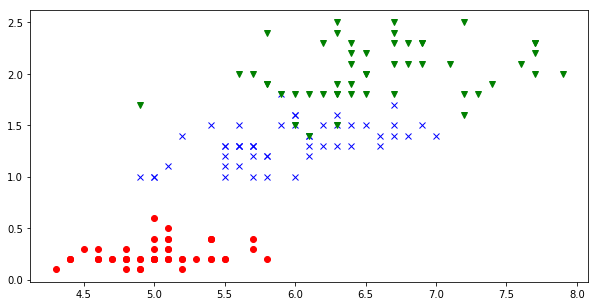

In [40]:
plt.figure(figsize=(10,5))
plt.plot(class1_x, class1_y, "ro", label="Setosa")
plt.plot(class2_x, class2_y, "bx", label="Versicolor")
plt.plot(class3_x, class3_y, "gv", label="Virgínica")
plt.show()

In [41]:
batch_size = len(x_vals)

x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[3, None], dtype=tf.float32) # 3 valores de predicción distintos
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

b = tf.Variable(tf.random_normal(shape=[3, batch_size]))

In [42]:
gamma = tf.constant(-10.0)

dist = tf.reduce_sum(tf.square(x_data), axis=1) # Sumatorio por columnas
dist = tf.reshape(dist, [-1,1]) # Para poder hacer las opeeraciones matriciales
sq_distance = tf.add(tf.subtract(dist, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(x_data)))), 
                     tf.transpose(dist))

# Kernel Gaussiano
kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_distance))) 

Antes podíamos hacer $X^T \cdot X$

In [43]:
def reshape_matmul(matrix):
    v1 = tf.expand_dims(matrix, 1)
    v2 = tf.reshape(v1, [3, batch_size, 1])
    return tf.matmul(v2, v1)

In [44]:
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = reshape_matmul(y_target)

second_term = tf.reduce_sum(tf.multiply(kernel, tf.multiply(b_vec_cross, y_target_cross)), [1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))

In [45]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), axis=1), [-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), axis=1), [-1,1])

pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(prediction_grid)))), 
                      tf.transpose(rB))

pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

In [46]:
prediction_output = tf.matmul(tf.multiply(y_target, b), pred_kernel)
prediction = tf.argmax(prediction_output - tf.expand_dims(tf.reduce_mean(prediction_output, axis=1), axis=1), 
                        axis=0)

In [47]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_target, axis=0)), tf.float32))

In [48]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
session.run(init)

In [49]:
loss_vector = []
accuracy_vector = []

for i in range(200):
    rand_idx = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_idx]
    rand_y = y_vals[:, rand_idx] # Es un vector de vectores
    session.run(train, feed_dict={x_data: rand_x, 
                                  y_target: rand_y})
    
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, 
                                             y_target: rand_y})
    
    loss_vector.append(temp_loss)
    
    temp_acc = session.run(accuracy, feed_dict={x_data: rand_x, 
                                                y_target: rand_y, 
                                                prediction_grid: rand_x})
    
    accuracy_vector.append(temp_acc)
    
    if (i+1)%25 == 0:
        print("Step #{} ==> Loss: {}, Accuracy: {}".format(i+1, temp_loss, temp_acc))

Step #25 ==> Loss: 23.26738166809082, Accuracy: 0.7400000095367432
Step #50 ==> Loss: -26.618154525756836, Accuracy: 0.9599999785423279
Step #75 ==> Loss: -36.97133255004883, Accuracy: 0.9399999976158142
Step #100 ==> Loss: -28.643840789794922, Accuracy: 0.9666666388511658
Step #125 ==> Loss: -31.061433792114258, Accuracy: 0.95333331823349
Step #150 ==> Loss: -37.425209045410156, Accuracy: 0.9333333373069763
Step #175 ==> Loss: -35.455284118652344, Accuracy: 0.9800000190734863
Step #200 ==> Loss: -36.68348693847656, Accuracy: 0.9866666793823242


In [51]:
x_min, x_max = x_vals[:,0].min()-1, x_vals[:,0].max()+1
y_min, y_max = x_vals[:,1].min()-1, x_vals[:,1].max()+1

# Return coordinate matrices from coordinate vectors
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]

grid_predictions = session.run(prediction, feed_dict={x_data: x_vals, 
                                                        y_target: y_vals, 
                                                        prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

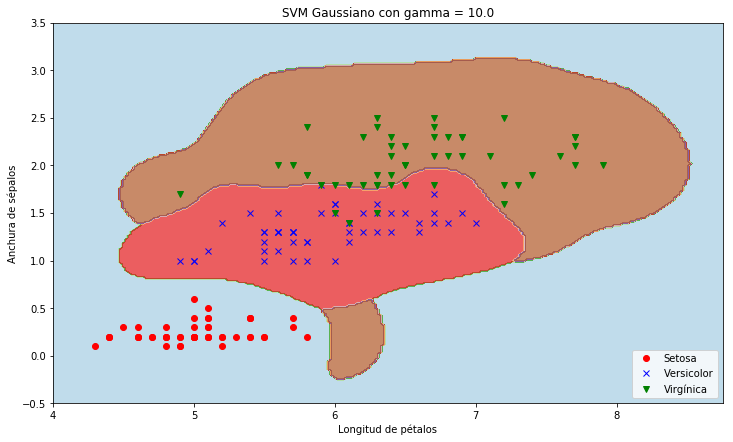

In [57]:
plt.figure(figsize=(12,7))
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.7)
plt.plot(class1_x, class1_y, "ro", label="Setosa")
plt.plot(class2_x, class2_y, "bx", label="Versicolor")
plt.plot(class3_x, class3_y, "gv", label="Virgínica")
plt.title("SVM Gaussiano con gamma = {}".format(-session.run(gamma)))
plt.xlabel("Longitud de pétalos")
plt.ylabel("Anchura de sépalos")
plt.xlim([4, 8.75])
plt.ylim([-0.5, 3.5])
plt.legend(loc="lower right")
plt.show()

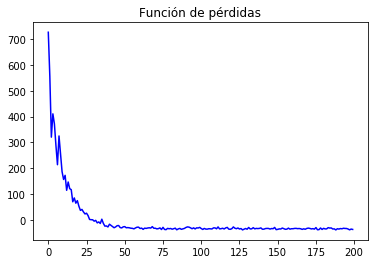

In [60]:
plt.plot(loss_vector, "b")
plt.title("Función de pérdidas")
plt.show()

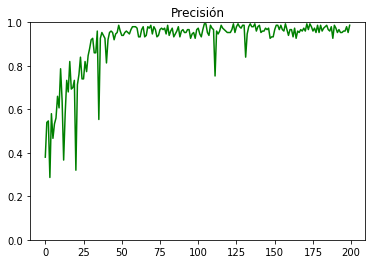

In [62]:
plt.plot(accuracy_vector, "g")
plt.title("Precisión")
plt.ylim([0,1])
plt.show()